In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [61]:
from .. import get_model_memory

ImportError: attempted relative import with no known parent package

In [45]:
# data cleaning
data = pd.read_csv('../Scraper/open-llm-leaderboard.csv') # read the full leaderboard

In [46]:
# fixing a mistake for microsoft's phi-1_5
data.loc[data['Model_name_for_query']=='microsoft/phi-1_5', '#Params (B)'] = 1.3
# fixing a mistake for roneneldan/TinyStories-1M
data.loc[data['Model_name_for_query']=='roneneldan/TinyStories-1M', '#Params (B)'] = 0.001
# removing models with size 0
data = data.loc[data['#Params (B)'] != 0]
# change the type of lamini 774M to Finetuned
data.loc[data['Model_name_for_query']=='MBZUAI/LaMini-GPT-774M', 'Type'] = "fine-tuned"

In [47]:
data.loc[data['Model_name_for_query']=='MBZUAI/LaMini-GPT-774M', ] #MBZUAI/LaMini-GPT-774M

,Type,Model_repo,Model_experiment_details,Average,ARC,HellaSwag,MMLU,TruthfulQA,Winogrande,GSM8K,DROP,Precision,Hub_License,#Params (B),Hub_like,Available_on_the_hub,Model_sha,Model_name_for_query
1396,fine-tuned,https://huggingface.co/MBZUAI/LaMini-GPT-774M,https://huggingface.co/datasets/open-llm-leade...,29.59,27.65,43.81,26.3,40.26,56.59,0.0,12.51,torch.float16,cc-by-nc-4.0,0.77,8.0,True,4f3bd4b37d249e6aa335be677afd39f417e05b5d,MBZUAI/LaMini-GPT-774M


In [48]:
'''
Optional Method: using second-hand API
'''
# from gradio_client import Client
# import json
# client = Client("https://felixz-open-llm-leaderboard.hf.space/")

# json_data = client.predict("","", api_name='/predict')

# with open(json_data, 'r') as file:
#     file_data = file.read()

# # Load the JSON data
# data = json.loads(file_data)

# # Get the headers and the data
# headers = data['headers']
# data = data['data']

'\nOptional Method: using second-hand API\n'

In [49]:
# data segmentation according to types
grouped = data.groupby('Type')
dataframes = {name: group for name, group in grouped} # create seperate dfs for each type of models
print(dataframes.keys())

# four type of models
RL_tuned_models = dataframes['RL-tuned']
fine_tuned_models = dataframes['fine-tuned']
instruction_tuned_models = dataframes['instruction-tuned']
pretrained_models = dataframes['pretrained']

print(len(RL_tuned_models), len(fine_tuned_models), len(instruction_tuned_models), len(pretrained_models)) # number of models of each type
print(len(data)-sum([len(RL_tuned_models), len(fine_tuned_models), len(instruction_tuned_models), len(pretrained_models)])) # some models have NaN types, 120
modelsets = []
modelsets.extend([RL_tuned_models, fine_tuned_models, instruction_tuned_models, pretrained_models, data])

dict_keys(['RL-tuned', 'fine-tuned', 'instruction-tuned', 'pretrained'])
15 1143 240 136
102


In [50]:
# visualization func
def visual(models, name):
    # Extract the values from the second dimension
    sizes = models['#Params (B)'].values

    # Plot the histogram
    plt.hist(sizes, bins='auto')  # 'auto' will automatically determine the number of bins
    plt.xlabel('#Params (B)')
    plt.ylabel('Frequency')
    plt.title(f'{name}: Distribution of #Params (B)')
    plt.show()

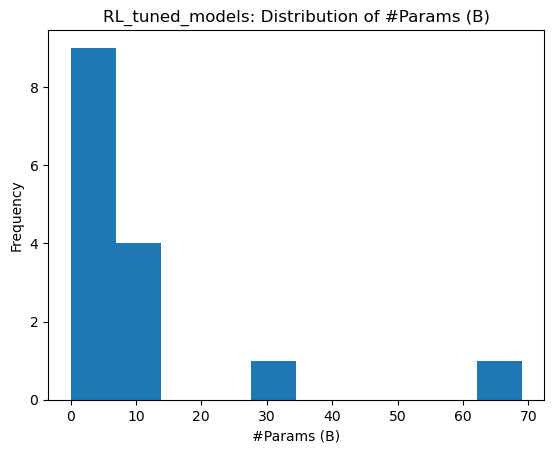

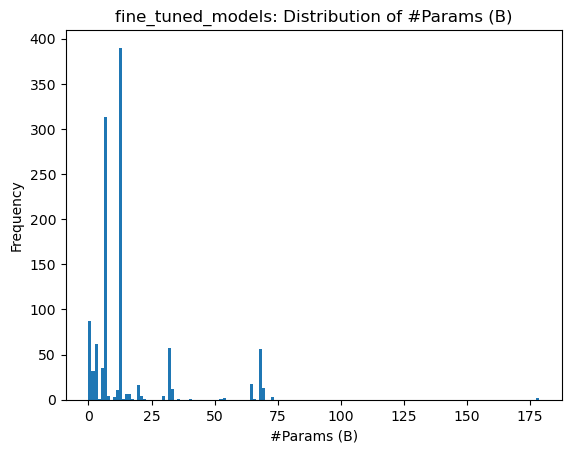

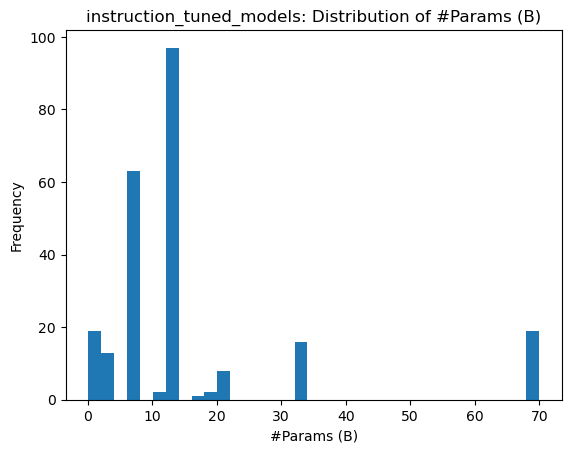

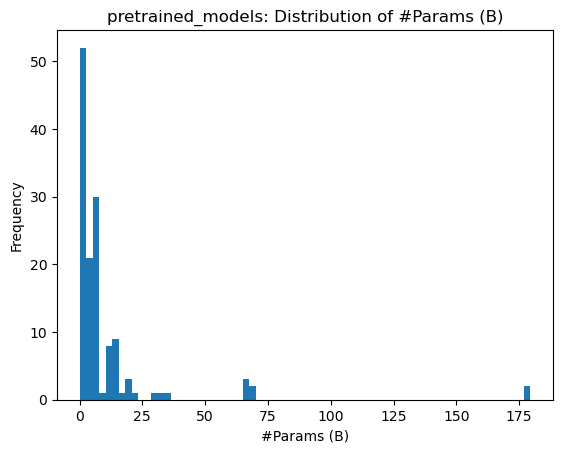

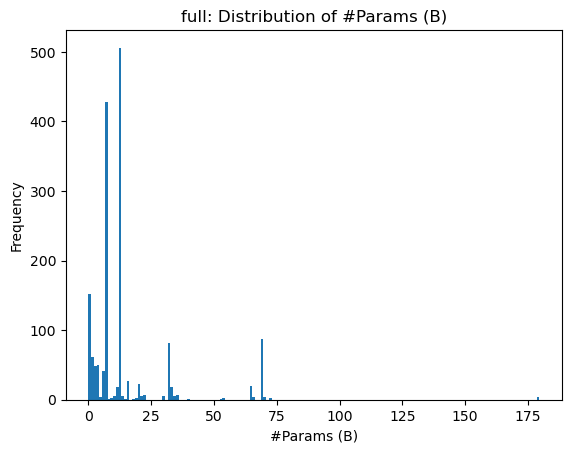

In [51]:
# visualize the distribution of model sizes
modelset_names = ["RL_tuned_models", "fine_tuned_models", "instruction_tuned_models", "pretrained_models", "full"]
for i, models in enumerate(modelsets):
    visual(models, modelset_names[i])

In [52]:
seperation = [1, 1.5, 3, 7, 13, 35, 60, 70] # model size ranges
# finding best model within each size range
def find_best_model(models):
    best_model_names = set()
    for i in range(len(seperation)+1):
        low = seperation[i-1] if i != 0 else 0
        high = seperation[i] if i != len(seperation) else None
        sub_models = models[models['#Params (B)'] >= low]
        if high: sub_models = sub_models[sub_models['#Params (B)'] < high] # if high is not None
        if len(sub_models) == 0: continue # skip if there are no models within this size range
        max_score_index = sub_models['Average'].idxmax()
        print(f'({low},{high})', sub_models.loc[max_score_index]["Model_name_for_query"])
        best_model_names.add(((low, high), sub_models.loc[max_score_index]["Model_name_for_query"]))
    return best_model_names

In [56]:
# # finding and printing best models
# best_models = []
# for i, models in enumerate(modelsets):
#     print(f'{modelset_names[i]}:')
#     best_models.append(find_best_model(models))
    
# finding and printing best models
best_models = []
with open('../best-models.txt', 'w') as f:  # Open a file to write the output
    for i, models in enumerate(modelsets):
        f.write(f"{modelset_names[i]}:\n")
        best_models.append(find_best_model(models))
        for model in best_models[-1]:  # Write the output of the last appended best model
            f.write(f"{model[0]}, {model[1]}\n")

(0,1) Locutusque/gpt2-large-conversational
(1,1.5) TheTravellingEngineer/bloom-1b1-RLHF-v2
(3,7) meta-llama/Llama-2-7b-chat-hf
(7,13) xxyyy123/mc_data_30k_from_platpus_orca_7b_10k_v1_lora_qkvo_rank14_v2
(13,35) Yhyu13/oasst-rlhf-2-llama-30b-7k-steps-hf
(60,70) meta-llama/Llama-2-70b-chat-hf
(0,1) MBZUAI/LaMini-GPT-774M
(1,1.5) euclaise/falcon_1b_stage3_2
(1.5,3) heegyu/RedTulu-Uncensored-3B-0719
(3,7) HyperbeeAI/Tulpar-7b-v0
(7,13) lvkaokao/mistral-7b-finetuned-orca-dpo-v2
(13,35) OpenBuddyEA/openbuddy-llama-30b-v7.1-bf16
(35,60) dfurman/falcon-40b-openassistant-peft
(60,70) sequelbox/StellarBright
(70,None) v2ray/LLaMA-2-Jannie-70B-QLoRA
(0,1) nicholasKluge/Aira-2-774M
(1,1.5) 42dot/42dot_LLM-SFT-1.3B
(1.5,3) RWKV/rwkv-raven-3b
(3,7) Azure99/blossom-v2-llama2-7b
(7,13) bhenrym14/mistral-7b-platypus-fp16
(13,35) garage-bAInd/Platypus-30B
(60,70) MayaPH/GodziLLa2-70B
(70,None) v2ray/LLaMA-2-Wizard-70B-QLoRA
(0,1) EleutherAI/pythia-410m
(1,1.5) microsoft/phi-1_5
(1.5,3) stabilityai/stabl

In [57]:
# # create a set to filter out duplicates
# models = set((*best_models[0], *best_models[1], *best_models[2], *best_models[3], *best_models[4]))
# for model in sorted(models, key=lambda x: x[0][0]):
#     print(model[0],model[1]) # print out sorted distinct model list

# create a set to filter out duplicates
models = set((*best_models[0], *best_models[1], *best_models[2], *best_models[3], *best_models[4]))
with open('../best-models-deduplicate.txt', 'w') as f:  # Open a file to write the output
    for model in sorted(models, key=lambda x: x[0][0]):
        f.write(f"{model[0]}, {model[1]}\n")  # Write each sorted model to the file